In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [2]:
import rasterio
from rasterio.windows import Window

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [5]:
DATA_PATH = '../input/hubmap-kidney-segmentation'
EPOCHES = 4
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [6]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [7]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=32, threshold = 100):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(
                    self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window,
                                   min_overlap=self.overlap)
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        idx = self.slices[index][0]
        filename = self.files[idx]
        x1,x2,y1,y2 = self.slices[index][1:] 
        with rasterio.open(filename, transform = identity) as dataset:
            image = dataset.read([1,2,3],
                        window=Window.from_slices((x1,x2),(y1,y2)))
            image = np.moveaxis(image, 0, -1)
            
        mask = self.masks[idx][x1:x2,y1:y2]
        
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [8]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

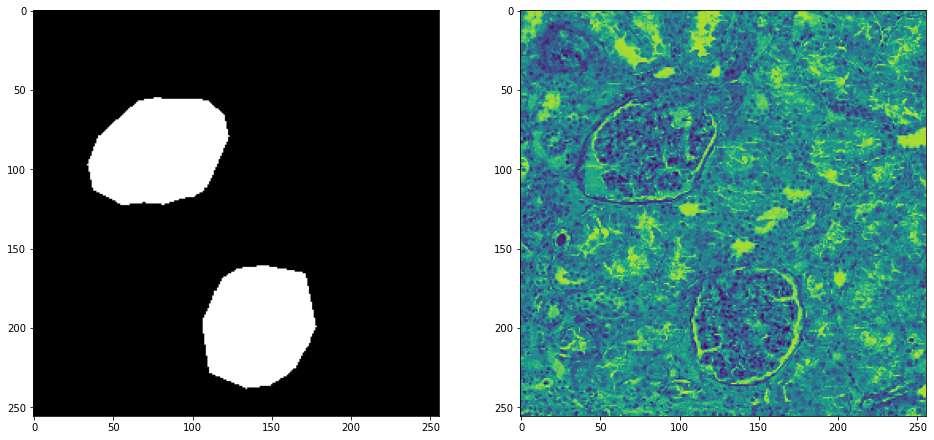

In [9]:
image, mask = ds[2]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

_ = rle_numba_encode(mask[0]) # compile function with numba

In [10]:
valid_idx, train_idx = [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 7:
        valid_idx.append(i)
    else:
        train_idx.append(i)

In [11]:
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [13]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [14]:
# deeplabv3_resnet101_coco-586e9e4e.pth  fcn_resnet50_coco-1167a1af.pth
# deeplabv3_resnet50_coco-cd0a2569.pth   resnet101-5d3b4d8f.pth
# fcn_resnet101_coco-7ecb50ca.pth        resnet50-19c8e357.pth
# Copy pretrain weight for model to cache dir
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/pytorch-pretrained-models/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth /root/.cache/torch/hub/checkpoints/

In [15]:
model = get_model()

model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [16]:
### Table for results
header = r'''
        Train | Valid
Epoch |  BCE  | BCE | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
print(header)

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in loader:
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []


        Train | Valid
Epoch |  BCE  | BCE | Time, m

     1│  0.302│  0.189│ 10.97
     2│  0.162│  0.161│ 10.60
     3│  0.127│  0.127│ 10.53
     4│  0.104│  0.106│ 10.63


In [18]:
# del train set
del loader, vloader, train_ds, valid_ds, ds
gc.collect();

In [19]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(NEW_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

model.eval()

p = pathlib.Path(DATA_PATH)

subm = {}

for i, filename in enumerate(p.glob('test/*.tiff')):
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
        image = trfm(image)
        with torch.no_grad():
            score = model(image.to(DEVICE)[None])['out'][0][0]
            score = score.cpu().numpy()
            score = cv2.resize(score, (WINDOW, WINDOW))
            preds[x1:x2,y1:y2] = (score > 0).astype(np.uint8)
            
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect();

In [20]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)